<a href="https://colab.research.google.com/github/klousss/applied_ai/blob/main/ai_lab3fix.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Практическая работа №3. Свёрточные нейронные сети

**Работу выполнил (а):**

Гуров Михаил Алексеевич 408510

# Классификация цветов с помощью свёрточных нейронных сетей.


В работе необходимо познакомится с различными архитектурами сверхточных нейронных сетей и их обучением на GPU (англ. graphics processing, графический процессор) на языке программирования Python 3 и фреймворка Torch (PyTorch).  Для этого предлагается использовать ресурсы Google Colab - Colaboratory, для выполнения вычислений на GPU. После с ознакомления, выполнить практическое задане в конце данной тетради (notebook).

Рассмотрим [Датасет](https://www.kaggle.com/alxmamaev/flowers-recognition ) содержащий 4242 изображения цветов размеченных по 5 видам (тюльпан, ромашка, подсолнух, роза, одуванчик). Данный набор данных можно скачать по [ссылке](https://www.kaggle.com/alxmamaev/flowers-recognition ) с сайте kaggle.

Загрузите папку с картинками на гугл диск, чтобы не загружать ее каждый раз заново при перезапуске колаба. Структура файлов (можно посмотреть в меню слева) может быть такой: "/content/drive/My Drive/data/flowers".

Обязательно подключите аппаратный ускоритель (GPU) к среде выполнения. В меню сверху: Среда выполнения -> Сменить среду выполнения

Первым делом разберите более детально код выполнив код ниже.

In [17]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("alxmamaev/flowers-recognition")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'flowers-recognition' dataset.
Path to dataset files: /kaggle/input/flowers-recognition


# Подготовка

Загружаем библиотеки. Фиксируем random.seed для воспроизводимости

In [18]:
import numpy as np
import os
import torch
import torchvision
from torchvision.datasets.utils import download_url
from torch.utils.data import random_split
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torchvision.transforms import ToTensor
from torch.utils.data.dataloader import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import random
from tqdm import tqdm
import matplotlib.pyplot as plt

random.seed(0)
torch.manual_seed(0)

Выбираем на чем будем делать вычисления - CPU или GPU (cuda)

In [19]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


Блок для соединения с Google Colab


In [ ]:
##from google.colab import drive

##drive.mount('/content/drive', force_remount=True)

##FOLDERNAME = 'data/flowers'

##assert FOLDERNAME is not None, "[!] Enter the foldername."

##%cd drive/My\ Drive
#%cp -r $FOLDERNAME ../../
#%cd ../../
##%cd data/flowers/
#!bash get_datasets.sh
#%cd ../../

#+For kaggle______________________________________________
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))
# FOLDERNAME = '/kaggle/input/flowers-recognition/flowers'
# %cd /kaggle/input/flowers-recognition/flowers

In [20]:
prepare_imgs = torchvision.transforms.Compose(
    [
        torchvision.transforms.Resize((224, 224)), #приводим картинки к одному размеру
        torchvision.transforms.ToTensor(), # упаковывем их в тензор
        torchvision.transforms.Normalize(
            mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225] # нормализуем картинки по каналам
        ),
    ]
)
# задаем датасет. Лейблы - имена папок:
dataset = ImageFolder('/kaggle/input/flowers-recognition/flowers', transform=prepare_imgs)
print(dataset.classes)
print(len(dataset.classes))

['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']
5


In [21]:
dataset.imgs[2]

('/kaggle/input/flowers-recognition/flowers/daisy/10172379554_b296050f82_n.jpg',
 0)

In [22]:
class ValueMeter(object):
  """
  Вспомогательный класс, чтобы отслеживать loss и метрику
  """
  def __init__(self):
      self.sum = 0
      self.total = 0

  def add(self, value, n):
      self.sum += value*n
      self.total += n

  def value(self):
      return self.sum/self.total

def log(mode, epoch, loss_meter, accuracy_meter, best_perf=None):
  """
  Вспомогательная функция, чтобы
  """
  print(
      f"[{mode}] Epoch: {epoch:0.2f}. "
      f"Loss: {loss_meter.value():.2f}. "
      f"Accuracy: {100*accuracy_meter.value():.2f}% ", end="\n")

  if best_perf:
      print(f"[best: {best_perf:0.2f}]%", end="")


# Сверточная нейросеть с нуля

## Вручную прописываем слои

In [23]:
model = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Flatten(),
            nn.Linear(256*28*28, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 5))
model.to(device) # отправляем модель на девайс (GPU)

Sequential(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU()
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU()
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU()
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU()
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU()
  (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (15): Flatten(start_dim=1, end_dim=-1)
  (16): Linear(in_features=200704, out_features=1024, bias=True)
  (17): ReLU()
  (18): Linear(in_features=1024, out_features=512, bias=True)
  (19): ReLU()
  (20): Lin

Задаем гиперпараметры для обучения:

# Задаем параметры и функцию для обучения. Разбиваем датасет на train/validation

In [24]:
batch_size = 32
optimizer = torch.optim.Adam(params = model.parameters())
lr = 0.001

Разбиваем датасет на train и validation

Задаем dataloader'ы - объекты для итеративной загрузки данных и лейблов для обучения и валидации

In [25]:
train_set, val_set = torch.utils.data.random_split(dataset, [len(dataset)-1000, 1000])
print('Размер обучающего и валидационного датасета: ', len(train_set), len(val_set))
loaders = {'training': DataLoader(train_set, batch_size, pin_memory=True,num_workers=2, shuffle=True),
           'validation':DataLoader(val_set, batch_size, pin_memory=True,num_workers=2, shuffle=False)}

Размер обучающего и валидационного датасета:  3317 1000


Функция для подсчета Accuracy

In [26]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

Функция для обучения и валидации модели

In [27]:
def trainval(model, loaders, optimizer, epochs=10):
    """
    model: модель, которую собираемся обучать
    loaders: dict с dataloader'ами для обучения и валидации
    """
    loss_meter = {'training': ValueMeter(), 'validation': ValueMeter()}
    accuracy_meter = {'training': ValueMeter(), 'validation': ValueMeter()}

    loss_track = {'training': [], 'validation': []}
    accuracy_track = {'training': [], 'validation': []}

    for epoch in range(epochs): # итерации по эпохам
        for mode in ['training', 'validation']: # обучение - валидация
            # считаем градиаент только при обучении:
            with torch.set_grad_enabled(mode == 'training'):
                # в зависимоти от фазы переводим модель в нужный ружим:
                model.train() if mode == 'training' else model.eval()
                for imgs, labels in tqdm(loaders[mode]):
                    imgs = imgs.to(device) # отправляем тензор на GPU
                    labels = labels.to(device)
                    bs = labels.shape[0]  # размер батча (отличается для последнего батча в лоадере)

                    preds = model(imgs) # forward pass - прогоняем тензор с картинками через модель
                    loss = F.cross_entropy(preds, labels) # считаем функцию потерь
                    acc = accuracy(preds, labels) # считаем метрику

                    # храним loss и accuracy для батча
                    loss_meter[mode].add(loss.item(), bs)
                    accuracy_meter[mode].add(acc, bs)

                    # если мы в фазе обучения
                    if mode == 'training':
                        optimizer.zero_grad() # обнуляем прошлый градиент
                        loss.backward() # делаем backward pass (считаем градиент)
                        optimizer.step() # обновляем веса
            # в конце фазы выводим значения loss и accuracy
            log(mode, epoch, loss_meter[mode], accuracy_meter[mode])

            # сохраняем результаты по всем эпохам
            loss_track[mode].append(loss_meter[mode].value())
            accuracy_track[mode].append(accuracy_meter[mode].value())
    return loss_track, accuracy_track

# Обучаем базовую модель

Проверим загрузку видеокарты, прежде чем запустить обучение:

Запускаем обучение на 10 эпох

In [28]:
loss_track, accuracy_track = trainval(model, loaders, optimizer, epochs=10)

100%|██████████| 104/104 [00:32<00:00,  3.16it/s]


[training] Epoch: 0.00. Loss: 1.40. Accuracy: 35.88% 


100%|██████████| 32/32 [00:04<00:00,  6.44it/s]


[validation] Epoch: 0.00. Loss: 1.44. Accuracy: 35.60% 


100%|██████████| 104/104 [00:32<00:00,  3.17it/s]


[training] Epoch: 1.00. Loss: 1.35. Accuracy: 39.43% 


100%|██████████| 32/32 [00:04<00:00,  6.54it/s]


[validation] Epoch: 1.00. Loss: 1.37. Accuracy: 36.30% 


100%|██████████| 104/104 [00:32<00:00,  3.18it/s]


[training] Epoch: 2.00. Loss: 1.28. Accuracy: 44.08% 


100%|██████████| 32/32 [00:05<00:00,  6.38it/s]


[validation] Epoch: 2.00. Loss: 1.28. Accuracy: 42.50% 


100%|██████████| 104/104 [00:32<00:00,  3.17it/s]


[training] Epoch: 3.00. Loss: 1.20. Accuracy: 48.82% 


100%|██████████| 32/32 [00:05<00:00,  6.39it/s]


[validation] Epoch: 3.00. Loss: 1.22. Accuracy: 46.42% 


100%|██████████| 104/104 [00:32<00:00,  3.18it/s]


[training] Epoch: 4.00. Loss: 1.10. Accuracy: 53.75% 


100%|██████████| 32/32 [00:04<00:00,  6.48it/s]


[validation] Epoch: 4.00. Loss: 1.19. Accuracy: 49.50% 


100%|██████████| 104/104 [00:32<00:00,  3.17it/s]


[training] Epoch: 5.00. Loss: 0.99. Accuracy: 58.67% 


100%|██████████| 32/32 [00:04<00:00,  6.43it/s]


[validation] Epoch: 5.00. Loss: 1.27. Accuracy: 51.43% 


100%|██████████| 104/104 [00:32<00:00,  3.18it/s]


[training] Epoch: 6.00. Loss: 0.89. Accuracy: 63.30% 


100%|██████████| 32/32 [00:04<00:00,  6.74it/s]


[validation] Epoch: 6.00. Loss: 1.49. Accuracy: 52.37% 


100%|██████████| 104/104 [00:32<00:00,  3.18it/s]


[training] Epoch: 7.00. Loss: 0.80. Accuracy: 67.15% 


100%|██████████| 32/32 [00:04<00:00,  6.74it/s]


[validation] Epoch: 7.00. Loss: 1.61. Accuracy: 52.71% 


100%|██████████| 104/104 [00:32<00:00,  3.18it/s]


[training] Epoch: 8.00. Loss: 0.72. Accuracy: 70.45% 


100%|██████████| 32/32 [00:04<00:00,  7.05it/s]


[validation] Epoch: 8.00. Loss: 1.82. Accuracy: 53.07% 


100%|██████████| 104/104 [00:32<00:00,  3.17it/s]


[training] Epoch: 9.00. Loss: 0.67. Accuracy: 73.04% 


100%|██████████| 32/32 [00:04<00:00,  6.98it/s]

[validation] Epoch: 9.00. Loss: 1.92. Accuracy: 53.39% 


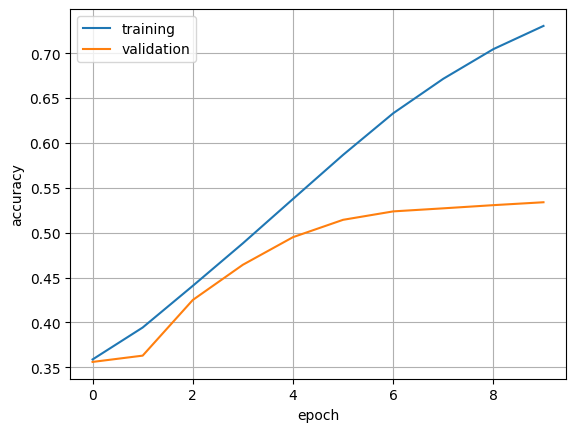

In [29]:
from matplotlib import pyplot as plt
%matplotlib inline
plt.plot(accuracy_track['training'], label='training')
plt.plot(accuracy_track['validation'], label='validation')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.grid()
plt.legend()

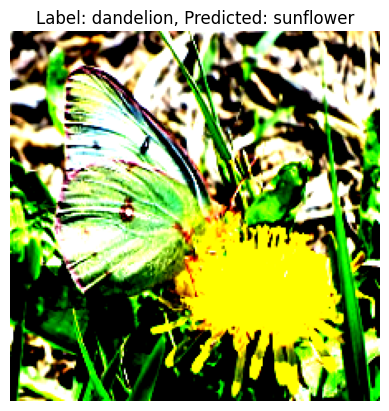

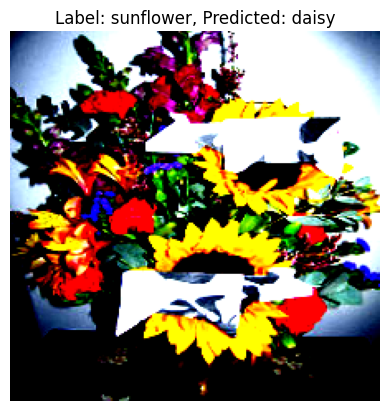

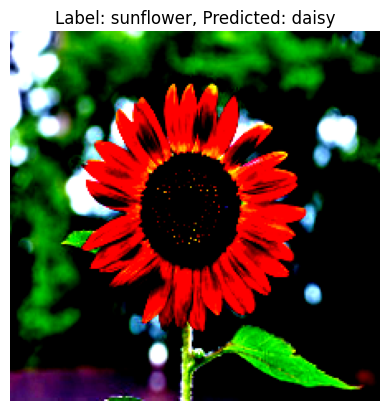

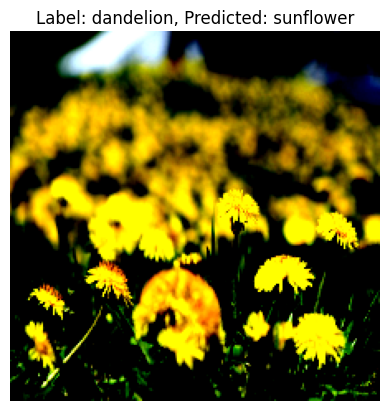

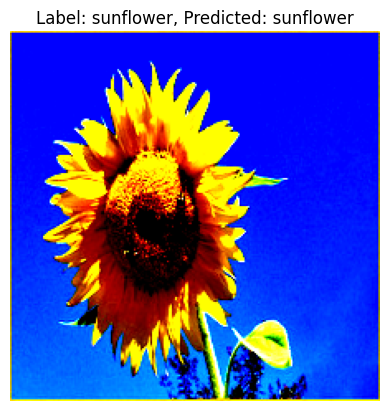

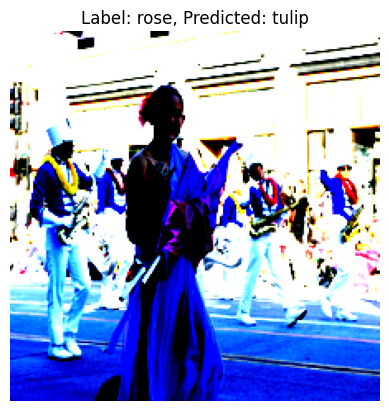

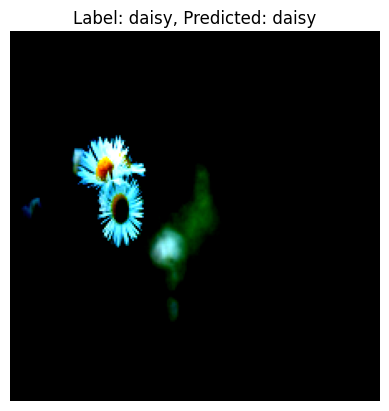

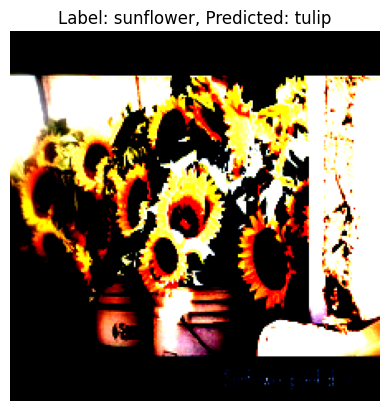

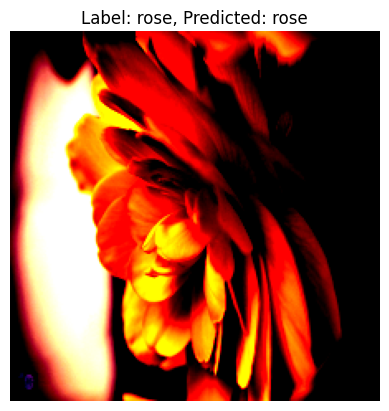

In [30]:
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

def predict_image(img, model):
    # Преобразование to a batch of 1
    xb = img.unsqueeze(0).to(device)
    # Получение прогнозов от модели
    yb = model(xb)
    # Выбираем индекс с наибольшей вероятностью
    _, preds  = torch.max(yb, dim=1)
    # Получение метки класса
    return dataset.classes[preds[0].item()]

for i in range(1,10):
  img, label = val_set[i]
  plt.imshow(img.clip(0,1).permute(1, 2, 0))
  plt.axis('off')
  plt.title('Label: {}, Predicted: {}'.format(dataset.classes[label],predict_image(img, model)))
  plt.show()

# Практическое задание



В задние представлено логика выполнения с использование tensorflow/keras. Выполнять можно как с использованием tensorflow/keras, так и pytorch.

1. Необходимо обучить предобученную сверточную архитектуру для задач классификации цветов.

В выбранной Вами архитектуре также необходимо **разобраться** с основными её параметрами и принципами работы.

Посмотрите как использовать [модели в PyTorch](https://pytorch.org/vision/stable/models.html) для классификации, выберите одну и используя transfer learning до-обучите модель на классификацию цветов. Чтобы это сделать замените ____ в ячейках ниже на работающий код.

2. Реализовать свою архитектуру, также как в разделе "Сверточная нейросеть с нуля".

3. Сравнить три архитектуры (из раздела "Сверточная нейросеть с нуля", предобученую сверточную архитектуру и свою архитектуру (из п. 2)). Визуализировать полученный результат сравнения.





1. Обучение предобученной сверточной архитектуры для задач классификации цветов

In [31]:

# Выберите модель из списка доступных в PyTorch моделей
# Не забудьте указать, что она модель должна быть предобучена!
# Возьмём ResNet-18
model = torchvision.models.resnet18(pretrained=True)
model

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 195MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [32]:
# Функция для заморозки весов модели
def set_parameter_requires_grad(model):
  for param in model.parameters():
    param.requires_grad = False

set_parameter_requires_grad(model) # передайте модель в функцию для "заморозки" градиента, "замораживаем" все слои

In [33]:
#model._____ = _____ Меняем последний слой модели Зачем? Сколькой нужно выходов?
# Для ResNet-18 последний слой — model.fc
# Нужно 5 выходов (5 классов цветов)
in_features = model.fc.in_features
model.fc = nn.Linear(in_features, 5)


In [34]:
# Проверим все ли сработало правильно, выведем веса, которые будут обучаться
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name)

fc.weight
fc.bias


In [35]:
model.to(device) # Отправляем модель на GPU
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3) # алгоритм оптимизации, оптимизируем только обучаемые параметры
loss_track_resnet, accuracy_track_resnet = trainval(model, loaders, optimizer, epochs=10) #обратить внимание на loss_track и accuracy_track

100%|██████████| 104/104 [00:12<00:00,  8.41it/s]


[training] Epoch: 0.00. Loss: 0.89. Accuracy: 68.83% 


100%|██████████| 32/32 [00:04<00:00,  7.31it/s]


[validation] Epoch: 0.00. Loss: 0.54. Accuracy: 83.60% 


100%|██████████| 104/104 [00:12<00:00,  8.42it/s]


[training] Epoch: 1.00. Loss: 0.70. Accuracy: 76.03% 


100%|██████████| 32/32 [00:03<00:00,  9.36it/s]


[validation] Epoch: 1.00. Loss: 0.48. Accuracy: 84.45% 


100%|██████████| 104/104 [00:12<00:00,  8.48it/s]


[training] Epoch: 2.00. Loss: 0.60. Accuracy: 79.55% 


100%|██████████| 32/32 [00:03<00:00,  9.19it/s]


[validation] Epoch: 2.00. Loss: 0.46. Accuracy: 84.97% 


100%|██████████| 104/104 [00:12<00:00,  8.55it/s]


[training] Epoch: 3.00. Loss: 0.54. Accuracy: 81.50% 


100%|██████████| 32/32 [00:04<00:00,  7.24it/s]


[validation] Epoch: 3.00. Loss: 0.44. Accuracy: 85.30% 


100%|██████████| 104/104 [00:11<00:00,  8.68it/s]


[training] Epoch: 4.00. Loss: 0.51. Accuracy: 82.86% 


100%|██████████| 32/32 [00:03<00:00,  8.95it/s]


[validation] Epoch: 4.00. Loss: 0.42. Accuracy: 85.52% 


100%|██████████| 104/104 [00:12<00:00,  8.66it/s]


[training] Epoch: 5.00. Loss: 0.48. Accuracy: 83.83% 


100%|██████████| 32/32 [00:03<00:00,  9.16it/s]


[validation] Epoch: 5.00. Loss: 0.41. Accuracy: 85.63% 


100%|██████████| 104/104 [00:12<00:00,  8.52it/s]


[training] Epoch: 6.00. Loss: 0.45. Accuracy: 84.57% 


100%|██████████| 32/32 [00:03<00:00,  9.14it/s]


[validation] Epoch: 6.00. Loss: 0.40. Accuracy: 85.97% 


100%|██████████| 104/104 [00:11<00:00,  8.69it/s]


[training] Epoch: 7.00. Loss: 0.43. Accuracy: 85.19% 


100%|██████████| 32/32 [00:04<00:00,  7.33it/s]


[validation] Epoch: 7.00. Loss: 0.39. Accuracy: 86.19% 


100%|██████████| 104/104 [00:12<00:00,  8.58it/s]


[training] Epoch: 8.00. Loss: 0.42. Accuracy: 85.81% 


100%|██████████| 32/32 [00:03<00:00,  9.26it/s]


[validation] Epoch: 8.00. Loss: 0.39. Accuracy: 86.37% 


100%|██████████| 104/104 [00:12<00:00,  8.53it/s]


[training] Epoch: 9.00. Loss: 0.41. Accuracy: 86.17% 


100%|██████████| 32/32 [00:03<00:00,  9.21it/s]

[validation] Epoch: 9.00. Loss: 0.38. Accuracy: 86.49% 


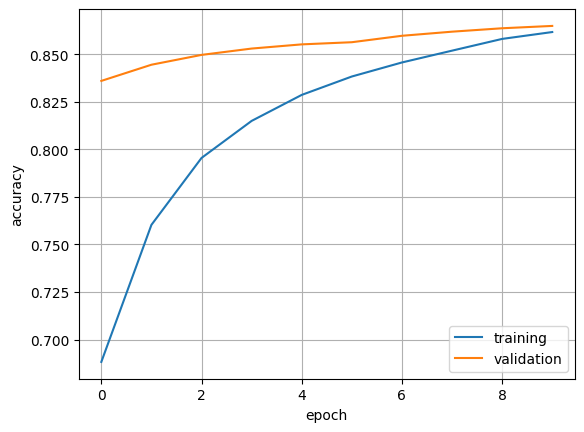

In [36]:
plt.plot(accuracy_track_resnet['training'], label='training')
plt.plot(accuracy_track_resnet['validation'], label='validation')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.grid()
plt.legend()

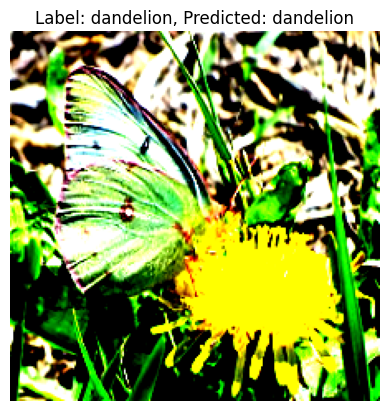

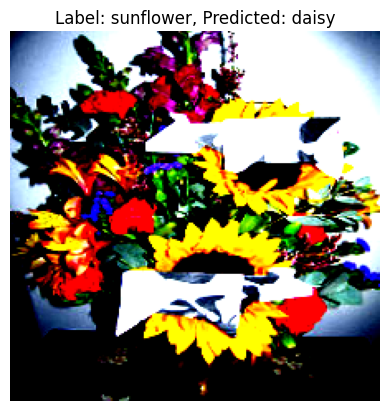

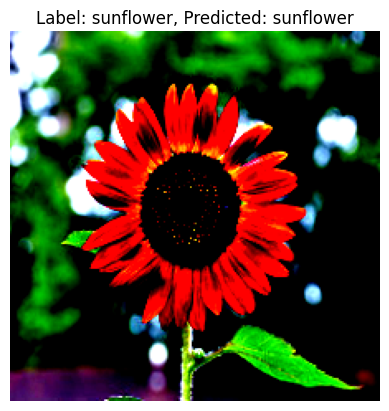

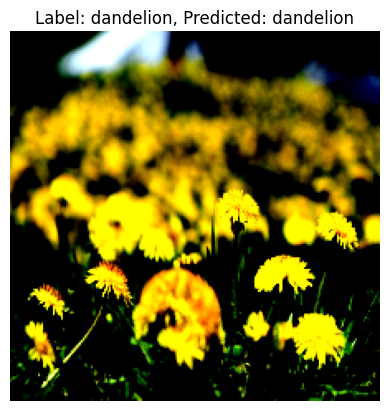

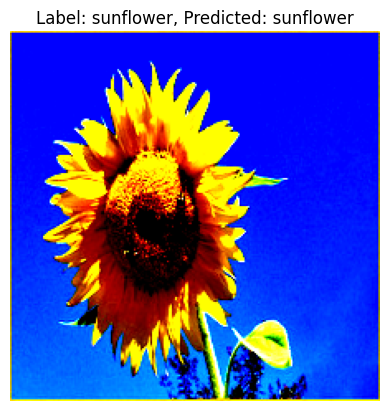

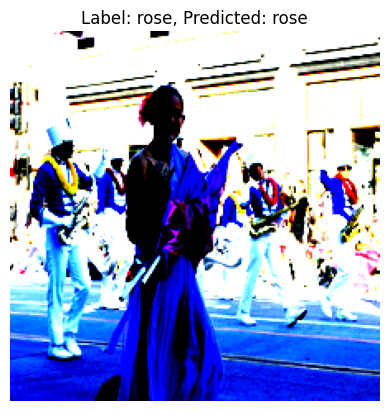

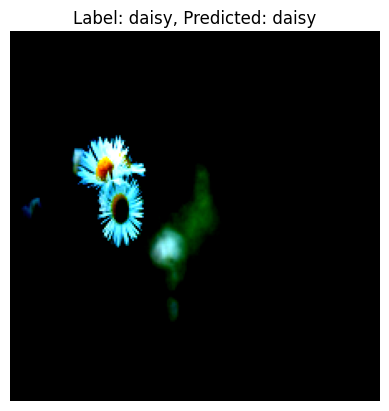

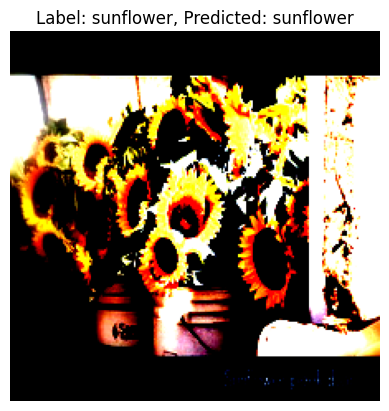

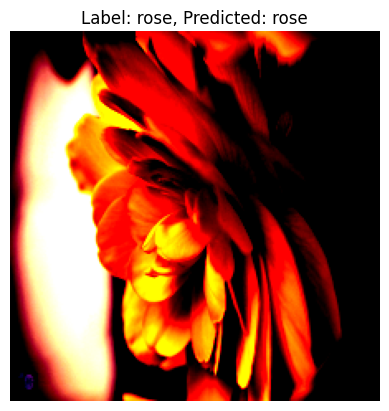

In [37]:
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

def predict_image(img, model):
    xb = img.unsqueeze(0).to(device)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return dataset.classes[preds[0].item()]

for i in range(1,10):
  img, label = val_set[i]
  plt.imshow(img.clip(0,1).permute(1, 2, 0))
  plt.axis('off')
  plt.title('Label: {}, Predicted: {}'.format(dataset.classes[label], predict_image(img, model)))
  plt.show()


По желанию, можно сохранить веса модели.

In [ ]:
#weights_fname = '/content/drive/My Drive/data/***___**.pth'
#torch.save(____.state_dict(), weights_fname)

2. Своя архитектура

100%|██████████| 104/104 [00:16<00:00,  6.48it/s]


[training] Epoch: 0.00. Loss: 1.43. Accuracy: 32.23% 


100%|██████████| 32/32 [00:03<00:00,  9.09it/s]


[validation] Epoch: 0.00. Loss: 1.26. Accuracy: 42.90% 


100%|██████████| 104/104 [00:13<00:00,  7.45it/s]


[training] Epoch: 1.00. Loss: 1.33. Accuracy: 39.10% 


100%|██████████| 32/32 [00:04<00:00,  7.15it/s]


[validation] Epoch: 1.00. Loss: 1.20. Accuracy: 46.35% 


100%|██████████| 104/104 [00:14<00:00,  7.42it/s]


[training] Epoch: 2.00. Loss: 1.27. Accuracy: 43.25% 


100%|██████████| 32/32 [00:03<00:00,  9.11it/s]


[validation] Epoch: 2.00. Loss: 1.17. Accuracy: 48.00% 


100%|██████████| 104/104 [00:13<00:00,  7.58it/s]


[training] Epoch: 3.00. Loss: 1.22. Accuracy: 46.10% 


100%|██████████| 32/32 [00:03<00:00,  8.33it/s]


[validation] Epoch: 3.00. Loss: 1.14. Accuracy: 50.30% 


100%|██████████| 104/104 [00:14<00:00,  7.28it/s]


[training] Epoch: 4.00. Loss: 1.18. Accuracy: 48.24% 


100%|██████████| 32/32 [00:03<00:00,  8.91it/s]


[validation] Epoch: 4.00. Loss: 1.11. Accuracy: 51.40% 


100%|██████████| 104/104 [00:14<00:00,  7.40it/s]


[training] Epoch: 5.00. Loss: 1.16. Accuracy: 49.92% 


100%|██████████| 32/32 [00:03<00:00,  9.08it/s]


[validation] Epoch: 5.00. Loss: 1.10. Accuracy: 52.22% 


100%|██████████| 104/104 [00:14<00:00,  7.34it/s]


[training] Epoch: 6.00. Loss: 1.13. Accuracy: 51.27% 


100%|██████████| 32/32 [00:04<00:00,  7.19it/s]


[validation] Epoch: 6.00. Loss: 1.08. Accuracy: 53.50% 


100%|██████████| 104/104 [00:14<00:00,  7.24it/s]


[training] Epoch: 7.00. Loss: 1.11. Accuracy: 52.65% 


100%|██████████| 32/32 [00:03<00:00,  8.87it/s]


[validation] Epoch: 7.00. Loss: 1.06. Accuracy: 54.75% 


100%|██████████| 104/104 [00:13<00:00,  7.45it/s]


[training] Epoch: 8.00. Loss: 1.09. Accuracy: 53.93% 


100%|██████████| 32/32 [00:04<00:00,  7.28it/s]


[validation] Epoch: 8.00. Loss: 1.05. Accuracy: 55.41% 


100%|██████████| 104/104 [00:14<00:00,  7.42it/s]


[training] Epoch: 9.00. Loss: 1.07. Accuracy: 55.08% 


100%|██████████| 32/32 [00:03<00:00,  9.06it/s]

[validation] Epoch: 9.00. Loss: 1.03. Accuracy: 56.24% 


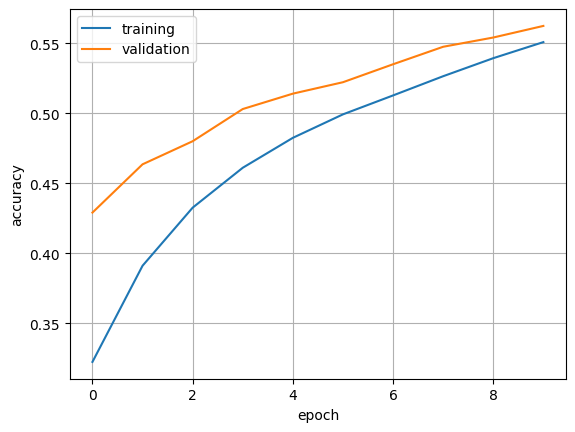

In [38]:
# Написать свой код здесь
class MyCNN(nn.Module):
    def __init__(self, num_classes=5):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.ReLU(),
            nn.Conv2d(32, 32, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),  # 224 -> 112

            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),  # 112 -> 56

            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),  # 56 -> 28
        )
        self.pool = nn.AdaptiveAvgPool2d((1,1))  # сгладим пространственный размер
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128, 128), nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.pool(x)
        x = self.classifier(x)
        return x

mycnn = MyCNN(num_classes=5).to(device)
optimizer_mycnn = torch.optim.Adam(mycnn.parameters(), lr=1e-3)

loss_track_mycnn, accuracy_track_mycnn = trainval(mycnn, loaders, optimizer_mycnn, epochs=10)

plt.plot(accuracy_track_mycnn['training'], label='training')
plt.plot(accuracy_track_mycnn['validation'], label='validation')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.grid()
plt.legend()






3. Сравнение и вузуализация 3-х архитектур

,model,val_accuracy
0,ResNet18 (TL),0.8649
1,MyCNN,0.5624
2,BaseCNN (from scratch),0.5339


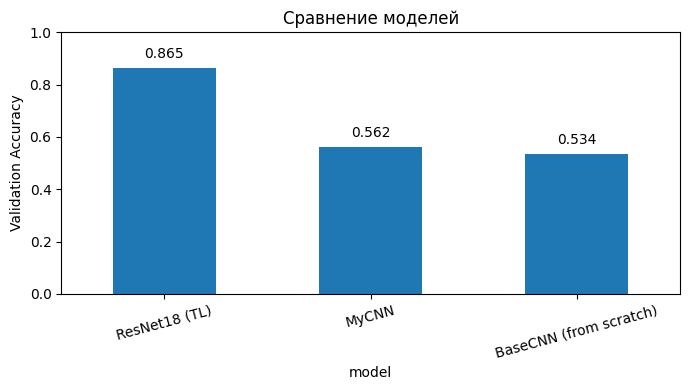

In [39]:
# Написать свой код здесь
import pandas as pd

# Попробуем взять базовую метрику, если есть переменные от "модели с нуля"
acc_train_base = accuracy_track['training'] if 'accuracy_track' in globals() else None
acc_val_base   = accuracy_track['validation'] if 'accuracy_track' in globals() else None

# Если базовой нет, обучим коротко твою "модель с нуля" из раздела выше (название там тоже model)
if acc_val_base is None:
    # переопределим base_cnn такой же, как в твоём разделе "с нуля" (короткая версия на 5 эпох)
    base_cnn = nn.Sequential(
        nn.Conv2d(3, 32, 3, padding=1), nn.ReLU(),
        nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(),
        nn.MaxPool2d(2,2),
        nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(),
        nn.Conv2d(128, 128, 3, padding=1), nn.ReLU(),
        nn.MaxPool2d(2,2),
        nn.Conv2d(128, 256, 3, padding=1), nn.ReLU(),
        nn.Conv2d(256, 256, 3, padding=1), nn.ReLU(),
        nn.MaxPool2d(2,2),
        nn.Flatten(),
        nn.Linear(256*28*28, 1024), nn.ReLU(),
        nn.Linear(1024, 512), nn.ReLU(),
        nn.Linear(512, 5)
    ).to(device)
    optimizer_base = torch.optim.Adam(base_cnn.parameters(), lr=1e-3)
    loss_track_base, accuracy_track_base = trainval(base_cnn, loaders, optimizer_base, epochs=5)
    acc_val_base = accuracy_track_base['validation']

# Берём финальные значения валидационной accuracy
final_val_base   = float(acc_val_base[-1])
final_val_mycnn  = float(accuracy_track_mycnn['validation'][-1])
final_val_resnet = float(accuracy_track_resnet['validation'][-1])

cmp_df = pd.DataFrame({
    'model': ['BaseCNN (from scratch)', 'MyCNN', 'ResNet18 (TL)'],
    'val_accuracy': [final_val_base, final_val_mycnn, final_val_resnet]
}).sort_values('val_accuracy', ascending=False).reset_index(drop=True)

display(cmp_df)

ax = cmp_df.plot(x='model', y='val_accuracy', kind='bar', rot=15, figsize=(7,4), legend=False)
ax.set_ylabel('Validation Accuracy')
ax.set_title('Сравнение моделей')
ax.set_ylim(0, 1)
# подписи над столбиками
for p in ax.patches:
    h = p.get_height()
    ax.annotate(f"{h:.3f}", (p.get_x()+p.get_width()/2, h), xytext=(0,5),
                textcoords="offset points", ha='center', va='bottom')
plt.tight_layout(); plt.show()

## Вопросы.
# Добавте описание архитектуры выбранной Вами предобученой сверточной нейронной сети.

В работе использовалась предобученная нейронная сеть ResNet-18.
Это глубокая сверточная модель, состоящая из последовательности блоков BasicBlock, каждый из которых включает две свёртки 3×3 и механизм остаточных связей (skip-connections).
Такие связи позволяют напрямую передавать информацию через несколько слоёв, что предотвращает деградацию качества и улучшает обучение глубоких сетей.

ResNet-18 обучена на большом датасете ImageNet (1,2 млн изображений, 1000 классов) и умеет извлекать универсальные визуальные признаки.
Для нашей задачи последний классификационный слой (fc) был заменён на Linear(in_features, 5) для классификации 5 видов цветов, а остальные слои были заморожены.

# Как работает выбранная вами модель сверточной нейронной сети? Какие параметры?

ResNet-18 принимает изображение, последовательно пропускает его через:
свёрточные слои (извлечение низкоуровневых признаков: контуры, углы),
глубокие блоки с остаточными связями (выделение более высокоуровневых признаков),
глобальный средний пулинг (уменьшение карты признаков),
полносвязный классификатор.

Количество параметров ResNet-18 — около 11,7 млн, но при transfer learning обучается только последний слой, остальные параметры заморожены.
Такая модель эффективно использует ранее изученные фильтры и позволяет быстро адаптироваться под новую задачу.

#В чем основные отличия между сверточной нейронной сетью и "обычной" полносвязной нейронной сетью?

1. Принцип работы слоёв:

Свёрточная сеть (CNN) использует локальные фильтры (например 3×3), которые обрабатывают изображение по частям.

Полносвязная сеть (Dense) соединяет каждый пиксель со всеми нейронами — это очень дорого и не учитывает структуру изображения.

2. Количество параметров:
CNN имеет значительно меньше параметров и эффективнее обучается на изображениях.
Dense сеть на изображении 224×224×3 требует сотни миллионов весов.

3. Иерархия признаков:
CNN автоматически извлекает признаки разной сложности: края → текстуры → формы → объекты.
Полносвязная сеть такого не умеет.

4. Инвариантность к сдвигам:
CNN меньше чувствительна к перемещению объектов по изображению благодаря свёрткам и пулингу.

#Что такое transfer learning? Что такое предобучена нейронная сеть?

Transfer learning — это техника, при которой уже обученная на большом датасете нейронная сеть используется как готовый извлекатель признаков.
Мы не обучаем модель с нуля, а берём её знания и адаптируем под новую задачу.

Предобученная нейронная сеть — это модель, которая уже прошла обучение (например, на ImageNet) и имеет устойчивые визуальные представления.
В нашей работе мы использовали ResNet-18 с весами pretrained=True.

#Что такое функция для заморозки весов модели?

Заморозка весов — это отключение вычисления градиентов для выбранных слоев.
Это делается для того, чтобы не обучать всю модель заново, а дообучать только последний классификационный слой.

```
for param in model.parameters():
    param.requires_grad = False
```

При заморозке: градиенты не считаются, веса не обновляются, обучение становится быстрее, уменьшается риск переобучения.

#Как работает блок "Сверточная нейросеть с нуля"? Описать сверточный и пулинговый слой.

В блоке «CNN с нуля» создаётся архитектура из нескольких последовательных слоёв:

Сверточный слой (Conv2D):
состоит из набора learnable фильтров (обычно 3×3),
скользит по изображению (операция свёртки),
извлекает локальные признаки: углы, линии, текстуры,
формирует карту признаков (feature map).

Пример эффекта свёртки: один фильтр выделяет вертикальные линии, другой — горизонтальные, третий — края объектов.

Пулинг (MaxPool2D):
уменьшает размер карты признаков,
выбирает максимум в окне (обычно 2×2),
делает сеть устойчивой к шуму и смещениям объекта,
уменьшает количество параметров.

Последовательное применение свёрток и пулинга формирует всё более сложные и абстрактные признаки изображения.
После нескольких блоков используется Flatten + несколько полносвязных слоев для финальной классификации.